In [1]:
import intake
import os.path
import xarray as xr
from utils import plotter
from analogs import calculate_analogs, load_LENS_dataset, print_analog_stats, plot_analog_validation
import xesmf as xe
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib
import cartopy

In [2]:
# lat, lon = 33.1072795,35.4688208
lat, lon = 20.194824,-100.9225607

In [3]:
URL = "/home/jhexr/code/clustering_analogs/data/aws-cesm1-le.json"
if not os.path.isfile(URL):
    URL = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/\
        catalogs/aws-cesm1-le.json"

In [4]:
#LENS_dataset = load_LENS_dataset(URL)
#LENS_dataset.to_netcdf("./data/Lens_dataset.nc")
LENS_dataset = xr.open_dataset('./data/Lens_dataset.nc')
print(LENS_dataset)

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, member_id: 40, time: 181)
Coordinates:
  * time       (time) object 1920-01-01 00:00:00 ... 2100-01-01 00:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
Data variables:
    TREFHT     (member_id, time, lat, lon) float32 ...
    PRECC      (member_id, time, lat, lon) float32 ...


In [ ]:
curr_analogs = calculate_analogs(
    LENS_dataset, lat, lon, 
    ['TREFHT', 'PRECC'], LENS_dataset, 
    '2000-01-01', '2009-12-31', 
    '2000-01-01', '2009-12-31')

In [ ]:
curr_analogs = curr_analogs.load()
print("Done")
print(curr_analogs)

In [5]:
curr_analogs = xr.load_dataset('./data/gto_cesm.nc')
curr_distances = curr_analogs['Standardized Euclidean Distance'].mean(dim='member_id')
da = curr_distances
cmap = 'Greens_r'
title = 'Current Climate Analogs for 2000-2009 Hula'
vmin = 0
vmax = 3
k = 3
location=(lon,lat)
mask_out_ocean = True
cbar_ylabel=None

In [6]:
# mask ocean
if mask_out_ocean:
    import xesmf as xe
    ds_in = xr.open_dataset("./data/lsmask.oisst.v2.nc")
    regridder = xe.Regridder(ds_in, da, 'nearest_s2d', reuse_weights=True)
    ds_in = regridder(ds_in).squeeze()
    da.values[ds_in['lsmask'] == 1] = np.nan

Reuse existing file: nearest_s2d_720x1440_192x288.nc
using dimensions ('lat', 'lon') from data variable lsmask as the horizontal dimensions for this dataset.


In [7]:
da_min = da.where(da != da.sel(lat=lat, lon=lon, method='nearest'))

df = da_min.to_dataframe().dropna()
df.reset_index(inplace=True)
print(df)

             lat     lon  Standardized Euclidean Distance
0     -90.000000    0.00                        36.365845
1     -90.000000    1.25                        36.285984
2     -90.000000    2.50                        36.281197
3     -90.000000    3.75                        36.278149
4     -90.000000    5.00                        36.366158
...          ...     ...                              ...
18473  83.403145  327.50                        23.556850
18474  83.403145  328.75                        23.543150
18475  83.403145  330.00                        23.494827
18476  83.403145  331.25                        23.432343
18477  83.403145  332.50                        23.290562

[18478 rows x 3 columns]


In [ ]:
#get top locations, substitute for kmeans
points = []
for _ in range(k):
    points.append(da_min.where(da_min==da_min.min(), drop=True).squeeze())
    da_min = da_min.where(da_min!=da_min.min(), drop=True).squeeze()
print("\npoints:")
print(points)
top_k=[(p.lon.item(), p.lat.item()) for p in points]

In [ ]:
print(df)
from sklearn.cluster import KMeans
plt.style.use('default')
x=np.array(df['lon'])
y=np.array(df['lat'])
plt.figure(figsize=(15, 10))
plt.scatter(x, y, s=5, cmap='viridis',c='orange',label='Analogs')
plt.title('Lat lon SED',fontsize=18, fontweight='bold')
plt.xlabel('Lon',fontsize=15)
plt.ylabel('Lat',fontsize=15)

In [ ]:
import pandas as pd
from sklearn import preprocessing

x = df[['Standardized Euclidean Distance']].values #returns a numpy array

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df['Standardized Euclidean Distance'] = pd.DataFrame(x_scaled)
print(df)


In [9]:
print(df['Standardized Euclidean Distance'].quantile(0.03))

3.315358989238739


In [10]:

df['temp'] = ""
df.loc[df['Standardized Euclidean Distance'] > df['Standardized Euclidean Distance'].quantile(0.03), 'temp'] = np.nan
df.loc[df['Standardized Euclidean Distance'] < df['Standardized Euclidean Distance'].quantile(0.03), 'temp'] = 1
print(df['Standardized Euclidean Distance'].quantile(0.1))


df = df.dropna()
df = df.drop(columns=['Standardized Euclidean Distance','temp'])
print(df)

7.0753889083862305
             lat     lon
6055  -29.685863  133.75
6056  -29.685863  135.00
6057  -29.685863  136.25
6058  -29.685863  137.50
6059  -29.685863  138.75
...          ...     ...
11137  33.455498   46.25
11202  33.455498  246.25
11203  33.455498  247.50
11252  34.397907   45.00
11371  35.340313   43.75

[555 rows x 2 columns]


             lat     lon
6055  -29.685863  133.75
6056  -29.685863  135.00
6057  -29.685863  136.25
6058  -29.685863  137.50
6059  -29.685863  138.75
...          ...     ...
11137  33.455498   46.25
11202  33.455498  246.25
11203  33.455498  247.50
11252  34.397907   45.00
11371  35.340313   43.75

[555 rows x 2 columns]


Text(0, 0.5, 'Lat')

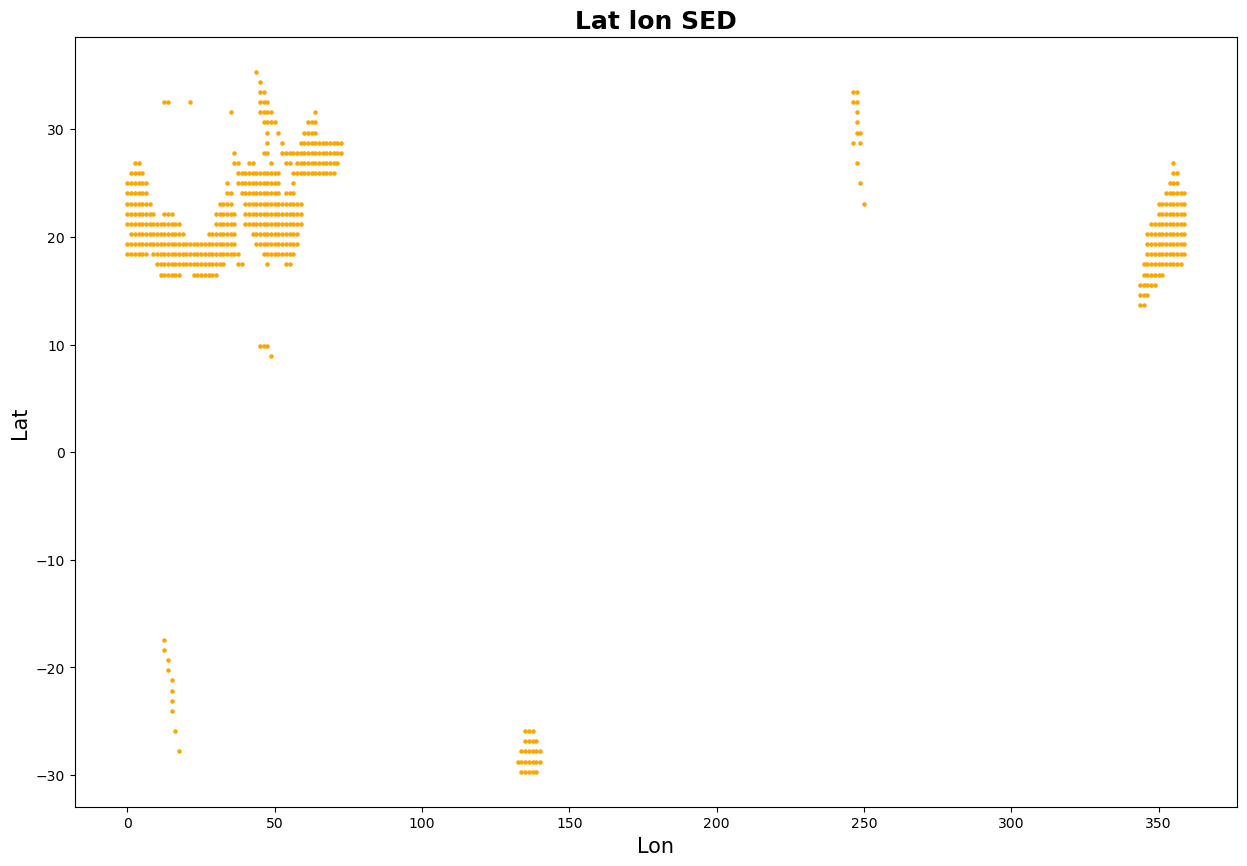

In [11]:
print(df)
from sklearn.cluster import KMeans
plt.style.use('default')
x=np.array(df['lon'])
y=np.array(df['lat'])
plt.figure(figsize=(15, 10))
plt.scatter(x, y, s=5, cmap='viridis',c='orange',label='Analogs')
plt.title('Lat lon SED',fontsize=18, fontweight='bold')
plt.xlabel('Lon',fontsize=15)
plt.ylabel('Lat',fontsize=15)

In [12]:
from sklearn.cluster import KMeans
x=np.array(df['lon'])
y=np.array(df['lat'])
# plt.style.use('default')
# plt.figure(figsize=(15, 10))
# plt.scatter(x, y, s=5, cmap='viridis',c='orange',label='Analogs')
# plt.title('Lat lon SED',fontsize=18, fontweight='bold')
# plt.xlabel('Lon',fontsize=15)
# plt.ylabel('Lat',fontsize=15)

In [13]:
X = np.array(df.astype(float))
print(X)

[[-29.68586349 133.75      ]
 [-29.68586349 135.        ]
 [-29.68586349 136.25      ]
 ...
 [ 33.45549774 247.5       ]
 [ 34.39790726  45.        ]
 [ 35.34031296  43.75      ]]


In [14]:
kmeans = KMeans(n_clusters=6, random_state=0,max_iter=1000)
kmeansclus_nw = kmeans.fit(df)
predicted_kmeans_nw = kmeans.predict(X)
centers_nw = kmeansclus_nw.cluster_centers_

# df['ClusterID_unwt'] = predicted_kmeans_nw
# centersdf_nw=pd.DataFrame(centers_nw)
# centersdf_nw['ClusterID_unwt'] = centersdf_nw.index
# centersdf_nw=centersdf_nw.rename(columns = {0:'Unwt Centroid: Spend in Local',1:'Unwt Centroid: Spend in Organic'})
# df_nw=df.merge(centersdf_nw,on='ClusterID_unwt',how='left')
# df_nw.head()

Text(0, 0.5, 'lat')

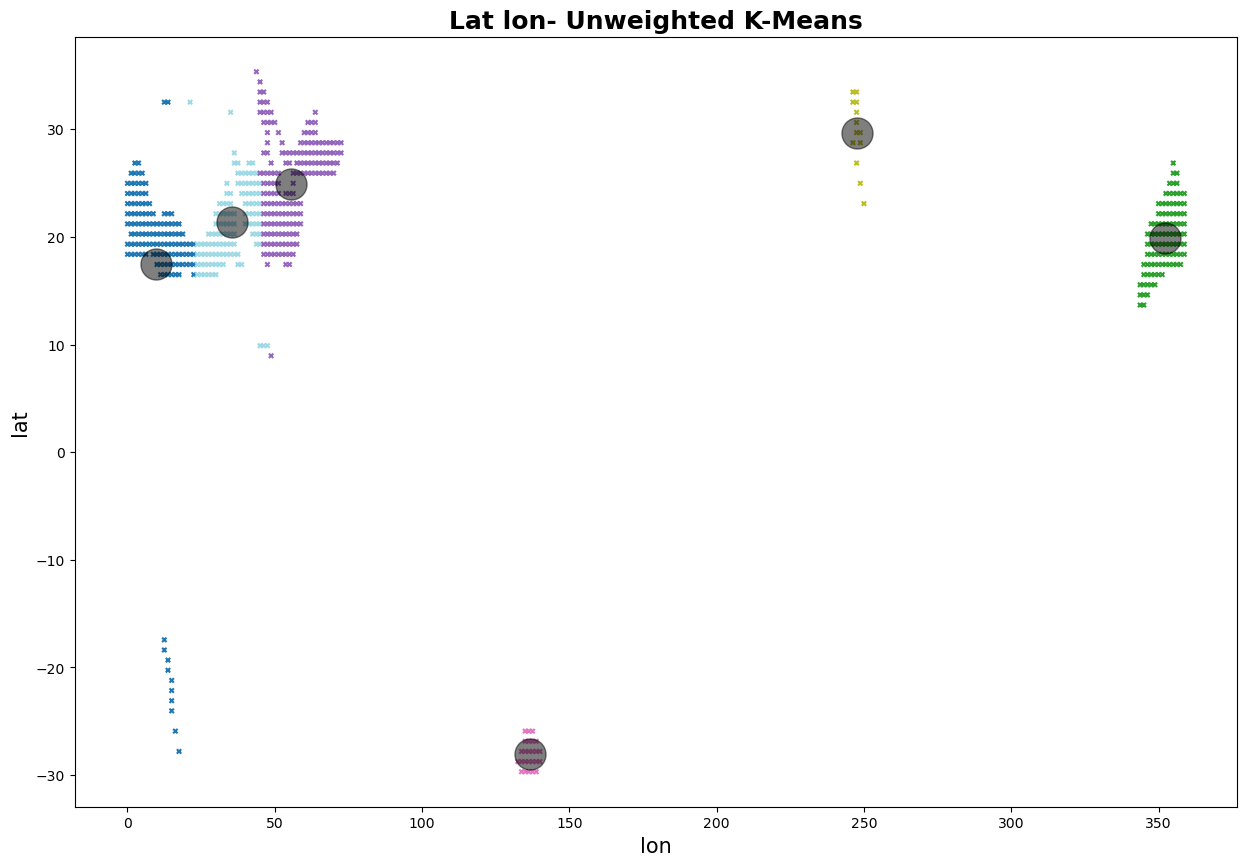

In [15]:
plt.figure(figsize=(15, 10))
plt.scatter(X[:, 1], X[:, 0], c=predicted_kmeans_nw, s=10, cmap='tab20',marker ='x')
plt.scatter(centers_nw[:, 1], centers_nw[:, 0], c='black', s=500, alpha=0.5);plt.title('Lat lon- Unweighted K-Means',fontsize=18, fontweight='bold')
plt.xlabel('lon',fontsize=15)
plt.ylabel('lat',fontsize=15)

In [16]:
print(centers_nw)

[[ 17.49881015   9.82954545]
 [ 19.88674007 352.10459184]
 [ 24.87403761  55.41176471]
 [-28.06492142 136.5       ]
 [ 29.68586379 247.69230769]
 [ 21.36528398  35.39529915]]


In [17]:
top_k=[(p[1], p[0]) for p in centers_nw]
print(top_k)

[(9.82954545454551, 17.49881014679416), (352.1045918367348, 19.88674007143292), (55.411764705882355, 24.87403760797836), (136.49999999999997, -28.064921417236334), (247.6923076923077, 29.685863788311288), (35.39529914529909, 21.365283982366563)]


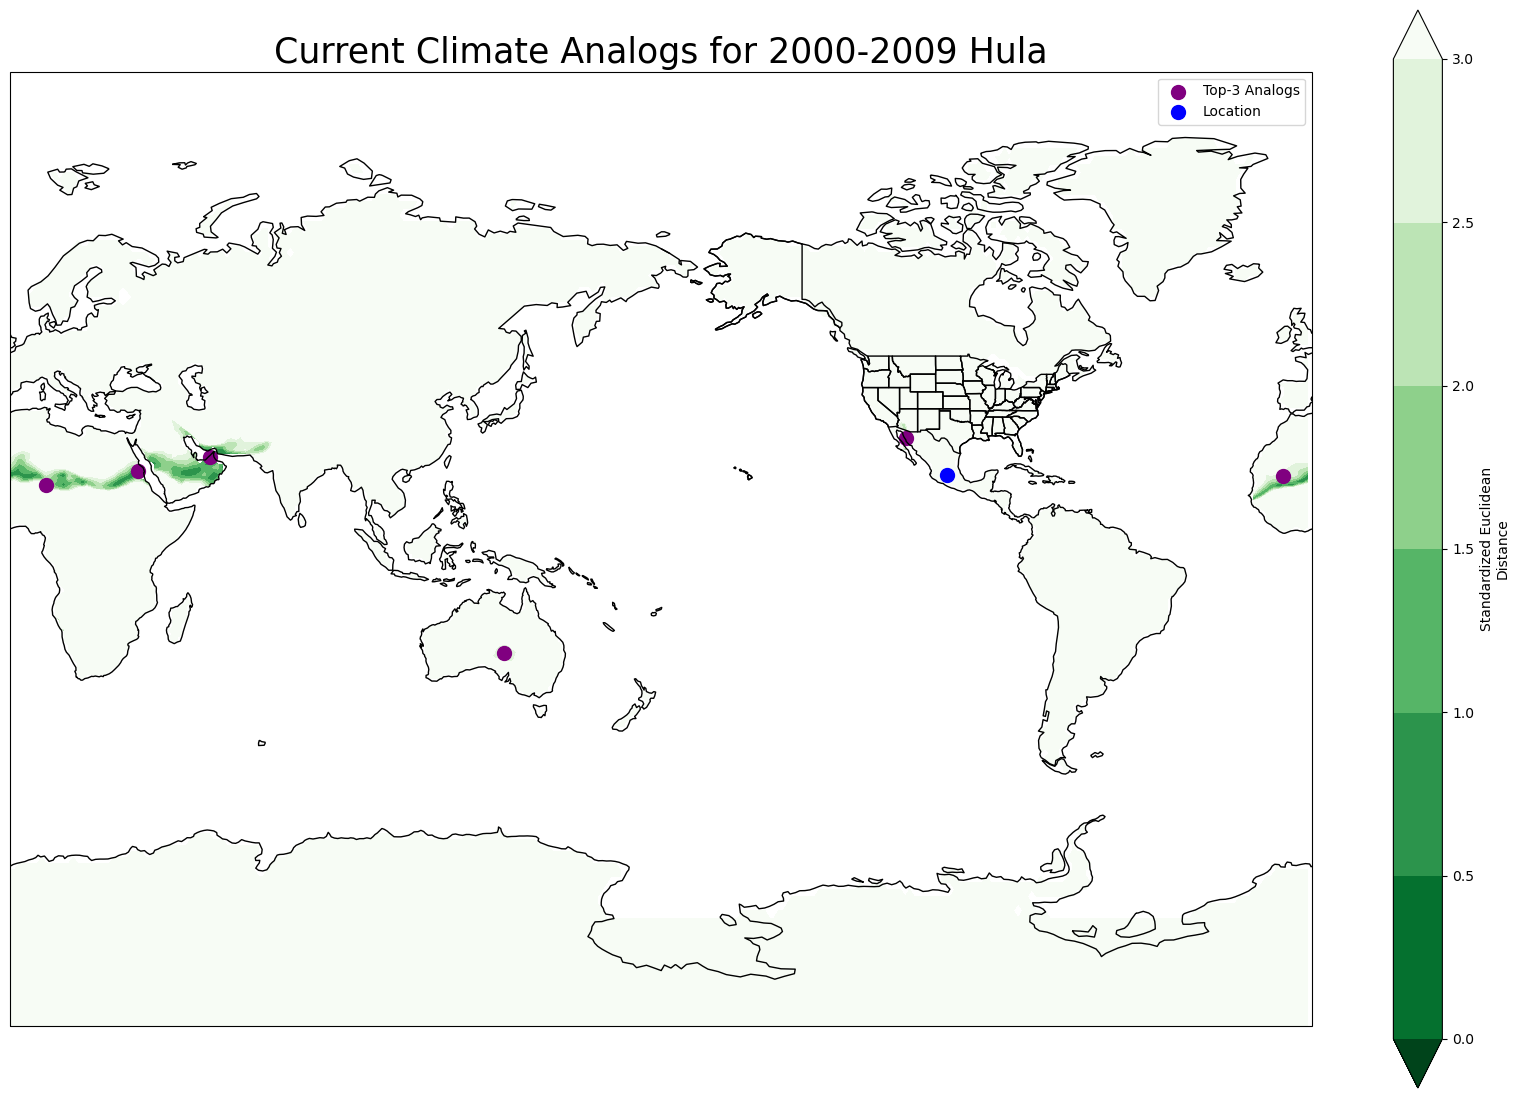

[(9.82954545454551, 17.49881014679416), (352.1045918367348, 19.88674007143292), (55.411764705882355, 24.87403760797836), (136.49999999999997, -28.064921417236334), (247.6923076923077, 29.685863788311288), (35.39529914529909, 21.365283982366563)]


In [18]:
# plot
plt.figure(figsize=(21,14))
ax = plt.axes(projection=ccrs.Miller(central_longitude=180))
contours = da.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
    cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
if cbar_ylabel:
    contours.colorbar.ax.set_ylabel(cbar_ylabel)
plt.title(title, size=25)
ax.set_global(); ax.coastlines(); ax.add_feature(cartopy.feature.STATES)

#plot points
if top_k:  
    ax.scatter([a[0] for a in top_k],[a[1] for a in top_k],
        transform=ccrs.PlateCarree(), color='purple',
        s=100, label = "Top-{} Analogs".format(k))
ax.scatter(*(location), transform=ccrs.PlateCarree(),
    color='blue', s=100, label="Location")
ax.legend()
plt.show()
print (top_k)